## Import required functions

In [1]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from xgboost  import XGBClassifier


from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## Helper functions

In [2]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])

In [3]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
            
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

## Loading Data

In [4]:
data= pd.read_csv("C:\\Users\\LENOVO\\Desktop\\Fraud.csv")
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
data.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0
6362619,743,CASH_OUT,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,1,0


## Data Dimension

In [6]:
print('Number of Rows: {}'.format(data.shape[0]))
print('Number of Cols: {}'.format(data.shape[1]))

Number of Rows: 6362620
Number of Cols: 11


## Data Types and Structures

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Missing values

In [8]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### There are no missing values in data

## Change datatype to help in data description

## Data Description

In [10]:
num_attributes = data.select_dtypes(exclude='object')
cat_attributes = data.select_dtypes(include='object')

## Numerical attributes

In [11]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02,7.420000e+02,0.584772,0.375177,0.329071
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07,9.244552e+07,3.357344,30.993949,1797.956705
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07,5.958504e+07,3.463606,5.249136,32.964879
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07,4.958504e+07,3.419485,5.176884,32.066985
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08,3.560159e+08,3.088194,19.921758,948.674125
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08,3.561793e+08,2.999298,19.352302,862.156508


* 50% of newbalance in original account is 0
* Skewness is in positive direction


## Categorical attributes

In [12]:
cat_attributes.describe()

,type,nameOrig,nameDest,isFraud,isFlaggedFraud
count,6362620,6362620,6362620,6362620,6362620
unique,5,6353307,2722362,2,2
top,CASH_OUT,C1902386530,C1286084959,no,no
freq,2237500,3,113,6354407,6362604


## Feature Engineering

In [5]:
data1=data.copy()

## No information has been given for those entities which have Merchant as the destination name



## Fix missing data:
Interpolating oldbalance and updating new balance with payment

In [6]:

data1.loc[data1['nameDest'].str.startswith('M'), ['oldbalanceDest']] = np.NaN
print('{} rows updated with NaN'.format(data1['oldbalanceDest'].isnull().sum()))

2151495 rows updated with NaN


In [7]:
data1=data1.interpolate()

Finding missing data after interpolation

In [9]:
data1[data1['oldbalanceDest'].isnull()]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,NaN,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,NaN,0.0,0,0


These are the 1st two rows in the dataset, and couldn't be interpolated. So let's assign oldbalanceDest for these to zero.

In [8]:
data1.loc[data1['oldbalanceDest'].isnull(), 'oldbalanceDest'] = 0

In [11]:
data1.isnull().values.any()

False

So, let's use a general update criteria for updating newbalanceDest

In [9]:
newbalanceDest = data1.loc[data1.nameDest.str.get(0) == 'M', 'oldbalanceDest'] + data1.loc[data1.nameDest.str.get(0) == 'M','amount']

In [10]:
data1.loc[data1['nameDest'].str.get(0) == 'M', ['newbalanceDest']] = newbalanceDest

In [14]:
len(data1[(data1['nameDest'].str.get(0) == 'M') & (data1['amount'] == data1['oldbalanceOrg'])])

0

No transactions to merchants try to empty funds in Original account.  
None of them need to be marked as isFraud.  
So we have fixed all missing data.

## EDA

### Response variable

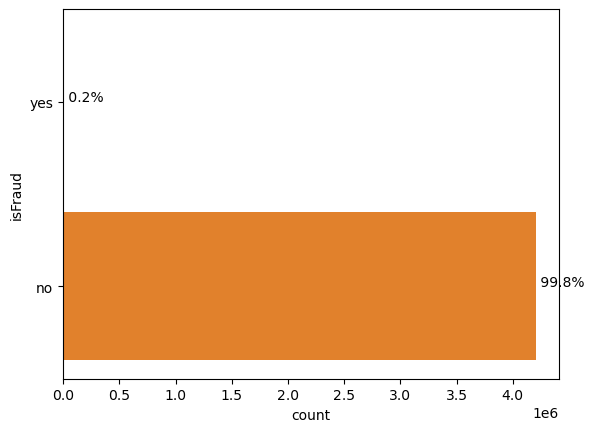

In [20]:
ax = sns.countplot(y='isFraud', data=data1);

total = data1['isFraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### Categorical variable

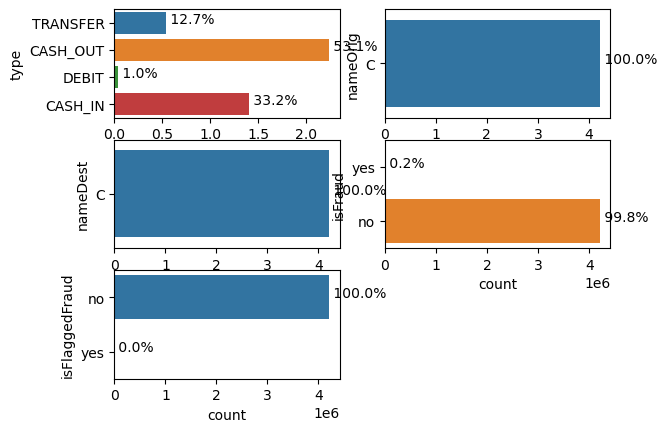

In [22]:
cat_attributes = data1.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

for column in columns:
    plt.subplot(3, 2, j)
    ax = sns.countplot(y=column, data=cat_attributes)
    
    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    
    j += 1

### Amount of fraud

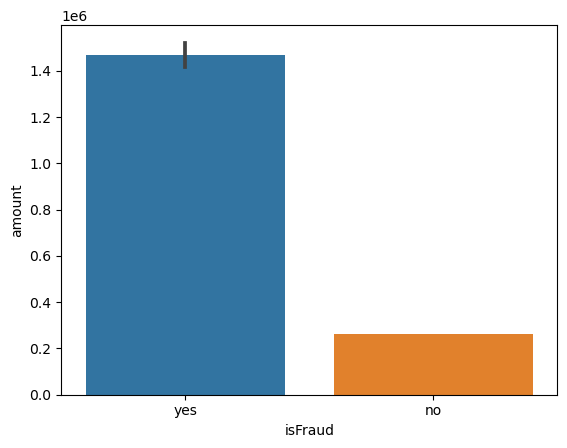

In [23]:
sns.barplot(y='amount', x='isFraud', data=data1);

In [25]:
print("Maximum fraud trasaction is Rs.",Fraud_data['amount'].max())
print("Minimum fraud trasaction is Rs.",Fraud_data['amount'].min())

Maximum fraud trasaction is Rs. 10000000.0
Minimum fraud trasaction is Rs. 0.0


### Fraud transactions in type of transactions

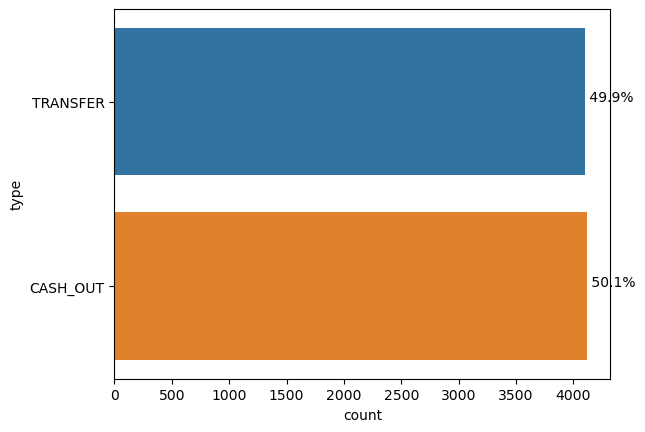

In [26]:
aux1 = data1[data1['isFraud'] == '1']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### Almost same fraud transactions happen in Transfer and Cash out type

## Flagged Fraud

Attempt to transfer => Original and destination accounts are not modified

In [15]:
len(data1[  (data1['oldbalanceOrg'] == data1['newbalanceOrig']) \
       & (data1['oldbalanceDest'] == data1['newbalanceDest']) \
       & (data1['amount']>200.000) \
       & (data1['type']=='TRANSFER') ])

21

In [16]:
len(data1[data1['isFlaggedFraud'] == 1])

16

In [17]:
dff_outliers = data1[  (data1['oldbalanceOrg'] == data1['newbalanceOrig']) \
       & (data1['oldbalanceDest'] == data1['newbalanceDest']) \
       & (data1['amount']>200.000) \
       & (data1['type']=='TRANSFER') \
       & (data1['isFlaggedFraud']==0)]
dff_outliers.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,5.00000,5.000000,5.0,5.0,5.0,5.0,5.0,5.0
mean,16.80000,237475.474000,0.0,0.0,0.0,0.0,0.0,0.0
std,16.11521,161578.156092,0.0,0.0,0.0,0.0,0.0,0.0
min,1.00000,18931.590000,0.0,0.0,0.0,0.0,0.0,0.0
25%,12.00000,133711.480000,0.0,0.0,0.0,0.0,0.0,0.0
50%,12.00000,271161.740000,0.0,0.0,0.0,0.0,0.0,0.0
75%,15.00000,342317.150000,0.0,0.0,0.0,0.0,0.0,0.0
max,44.00000,421255.410000,0.0,0.0,0.0,0.0,0.0,0.0


Outliers show pattern hence cannot be ignored

### Multiicollinearity

In [27]:
data1.select_dtypes(exclude='object').corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,diff_new_old_balance,diff_new_old_destiny
step,1.000000,0.028621,-0.009874,-0.010141,0.036444,0.034297,0.007490,0.002307
amount,0.028621,1.000000,-0.041776,-0.048015,0.260521,0.433038,0.132568,0.846072
oldbalanceOrg,-0.009874,-0.041776,1.000000,0.998768,0.023454,-0.003284,-0.200887,-0.110481
newbalanceOrig,-0.010141,-0.048015,0.998768,1.000000,0.024044,-0.004596,-0.249255,-0.118691
oldbalanceDest,0.036444,0.260521,0.023454,0.024044,1.000000,0.975226,-0.016934,0.214082
newbalanceDest,0.034297,0.433038,-0.003284,-0.004596,0.975226,1.000000,0.026642,0.424859
diff_new_old_balance,0.007490,0.132568,-0.200887,-0.249255,-0.016934,0.026642,1.000000,0.186943
diff_new_old_destiny,0.002307,0.846072,-0.110481,-0.118691,0.214082,0.424859,0.186943,1.000000


## Data Preparation

### Remove wanted columns

In [11]:
data1 = data1.drop(['nameOrig', 'nameDest'], axis=1)

### Normalization

In [12]:
cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
data1['step'] = data1['step'] - data1['step'].mean() / (data1['step'].std())
data1[cols] = data1[cols].apply(lambda x: (np.log(x+10)))

In [20]:
data1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,-0.710067,PAYMENT,9.195190,12.044412,11.984842,2.302585,9.195190,0,0
1,-0.710067,PAYMENT,7.535980,9.964536,9.872756,2.302585,7.535980,0,0
2,-0.710067,TRANSFER,5.252273,5.252273,2.302585,2.302585,2.302585,1,0
3,-0.710067,CASH_OUT,5.252273,5.252273,2.302585,9.961379,2.302585,1,0
4,-0.710067,PAYMENT,9.365474,10.634990,10.305475,10.112316,10.499926,0,0


In [13]:
# difference between initial balance before the transaction and new balance after the transaction
data1['diff_new_old_balance'] = data1['oldbalanceOrg']-data1['newbalanceOrig'] 

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
data1['diff_new_old_destiny'] = data1['newbalanceDest'] - data1['oldbalanceDest']



In [22]:
data1.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

#### The data is imbalaced, use SMOTE to deal with imbalace

In [14]:
from imblearn.over_sampling import SMOTE

### Convert String value into numerical value

In [15]:
X = data1
Y = data1['isFraud']          # target label
X = pd.concat([X, pd.get_dummies(X['type'])], axis = 'columns')       # one-hot columns for transaction type
X = X.drop(['isFraud', 'type'], axis=1)


In [25]:
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,diff_new_old_balance,diff_new_old_destiny,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,-0.710067,9.195190,12.044412,11.984842,2.302585,9.195190,0,0.059570,6.892605,False,False,False,True,False
1,-0.710067,7.535980,9.964536,9.872756,2.302585,7.535980,0,0.091779,5.233395,False,False,False,True,False
2,-0.710067,5.252273,5.252273,2.302585,2.302585,2.302585,0,2.949688,0.000000,False,False,False,False,True
3,-0.710067,5.252273,5.252273,2.302585,9.961379,2.302585,0,2.949688,-7.658794,False,True,False,False,False
4,-0.710067,9.365474,10.634990,10.305475,10.112316,10.499926,0,0.329514,0.387610,False,False,False,True,False


In [26]:
len(X)

6362620

SMOTE resampling

In [16]:
X, Y = SMOTE().fit_resample(X, Y)

In [28]:
len(X)

12708814

With smote resampling, now our dataset size has almost doubled and has balanced classes.

# Training

### Train, validation and test Split

Train: 80%, validation:10%, test:10%

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 55)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 0.5, random_state = 55)

# Machine Learning modeling

Before training, let's free up some RAM space.

In [18]:
import gc

In [19]:

del  X, Y, cols

In [20]:
gc.collect()

0

### Logistic regression

In [21]:
lg = LogisticRegression()
lg.fit(x_train, y_train)

y_pred = lg.predict(x_val)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
lg_results = ml_scores('Logistic Regression', y_val, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.973,0.961,0.986,0.973,0.945


### Classification Report

In [23]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97    636101
           1       0.96      0.99      0.97    634780

    accuracy                           0.97   1270881
   macro avg       0.97      0.97      0.97   1270881
weighted avg       0.97      0.97      0.97   1270881



### KNN

In [24]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred = knn.predict(x_val)

In [25]:
knn_results = ml_scores('K Nearest Neighbors', y_val, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.999,0.998,1.0,0.999,0.998


### Classification Report

In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    636101
           1       1.00      1.00      1.00    634780

    accuracy                           1.00   1270881
   macro avg       1.00      1.00      1.00   1270881
weighted avg       1.00      1.00      1.00   1270881



### XGBoost

In [21]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_val)

In [28]:
xgb_results = ml_scores('XGBoost', y_val, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.999,0.999,0.999,0.999,0.998


### Classification Report

In [29]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    636101
           1       1.00      1.00      1.00    634780

    accuracy                           1.00   1270881
   macro avg       1.00      1.00      1.00   1270881
weighted avg       1.00      1.00      1.00   1270881



## Comparing Model performance

In [30]:
modeling_performance = pd.concat([lg_results, knn_results, 
                                   xgb_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.973,0.961,0.986,0.973,0.945
K Nearest Neighbors,0.999,0.998,1.000,0.999,0.998
XGBoost,0.999,0.999,0.999,0.999,0.998


## Final model

In [22]:
final_model=xgb

## Evaluation

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate(trainedmodel, x, y):
  '''
    To evaluate model performance
  '''
  y_pred   = trainedmodel.predict(x)
  f1       = f1_score(y, y_pred)
  report   = classification_report(y, y_pred)
  acc      = accuracy_score(y, y_pred)
  roc_auc  = roc_auc_score(y, y_pred)

  eval = {'y_pred': y_pred, 
          'f1_score': f1,
          'accuracy':acc,
          'roc_auc_score': roc_auc
          }

  return eval, report

In [27]:
import pprint
pprint._sorted = lambda x:x

In [26]:
eval_test, report_test = evaluate(final_model, x_test, y_test)

In [28]:
print('Evaluation metrics on test data (for df): \n')
pprint.pprint(eval_test)
print('\n', report_test)

Evaluation metrics on test data (for df): 

{'accuracy': 0.998890534290359,
 'f1_score': 0.998889910625996,
 'roc_auc_score': 0.9988909703706893,
 'y_pred': array([0, 0, 0, ..., 0, 0, 0])}

               precision    recall  f1-score   support

           0       1.00      1.00      1.00    636076
           1       1.00      1.00      1.00    634806

    accuracy                           1.00   1270882
   macro avg       1.00      1.00      1.00   1270882
weighted avg       1.00      1.00      1.00   1270882



## Feature importance

In [29]:
from xgboost import plot_importance

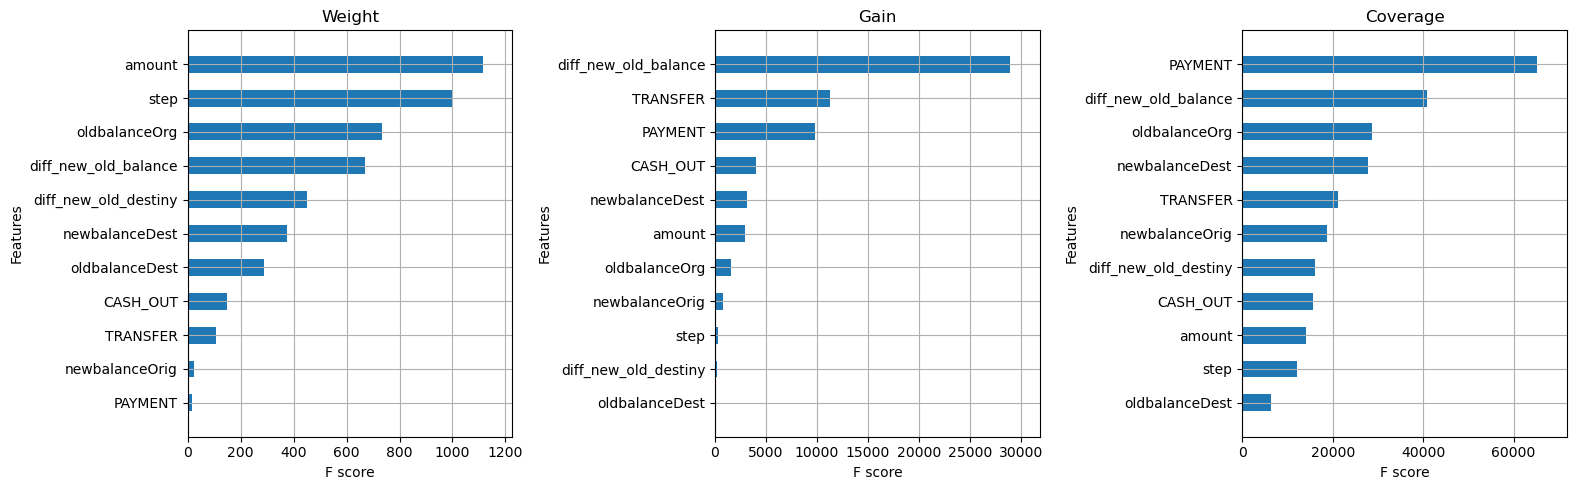

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))

plot_importance(booster=final_model, importance_type='weight', title='Weight', show_values=False, height=0.5, ax = ax[0])

# plot importances with split mean gain
plot_importance(booster=final_model, importance_type='gain', title='Gain', show_values=False, height=0.5, ax = ax[1])

# plot importances with sample coverage
plot_importance( booster=final_model, importance_type='cover', title='Coverage', show_values=False, height=0.5, ax = ax[2])

plt.tight_layout()
plt.show()

# Inference

* Both transfer and cashout contribute almost equally towards fraud.  
* oldbalance, newbalance and amount are interdependent variables.  
* diff_new_old_balace has the most gain, i.e. diff_new_old_balace contributed most towards model prediction.  
*  The most important features are diff_new_old_balace, oldbalanceOrg, amount and newbalanceDest.  


# Fraud prevention

* When updating the infrastructure for preventing fraud transactions, the company should lookout for anomalies in diff_new_old_balace.  
* A different criteria for flagging fraudulent transactions may also be useful.  
  
After updating the infrastructure, we can retrain the model using new data and compare the model performances to determine whether the updates will be successful towards proactive fraud detection.
